In [1]:
import tensorflow as tf
import numpy as np
import h5py

In [2]:
class NeuralFlux(tf.keras.Model):
    """
    Neural numerical flux for Burgers equation.
    Learns dissipation term phi_theta(uL, uR, mu).
    """

    def __init__(self, hidden_sizes=(64, 64), activation="tanh"):
        super().__init__()

        self.net = tf.keras.Sequential()
        for h in hidden_sizes:
            self.net.add(tf.keras.layers.Dense(h, activation=activation))
        self.net.add(tf.keras.layers.Dense(1, activation=None))

    @staticmethod
    def physical_flux(u):
        return 0.5 * tf.square(u)

    def call(self, inputs):
        """
        inputs: tensor of shape (batch, 3)
                columns = [uL, uR, log(mu)]
        returns: numerical flux f_theta
        """
        uL = inputs[:, 0:1]
        uR = inputs[:, 1:2]
        log_mu = inputs[:, 2:3]

        # dissipation coefficient
        phi = self.net(tf.concat([uL, uR, log_mu], axis=1))

        # base physical flux
        fL = self.physical_flux(uL)
        fR = self.physical_flux(uR)

        # consistent numerical flux
        f_hat = 0.5 * (fL + fR) + (uR - uL) * phi
        return f_hat


In [3]:
def load_interface_data(
    h5_path,
    max_cases=None,
    shuffle=True,
    seed=0
):
    uL_all, uR_all, mu_all = [], [], []

    with h5py.File(h5_path, "r") as f:
        cases = sorted(f["cases"].keys())
        if max_cases is not None:
            cases = cases[:max_cases]

        for name in cases:
            g = f["cases"][name]
            uL_all.append(g["uL"][:])
            uR_all.append(g["uR"][:])
            mu_all.append(g["mu_vec"][:])

    uL = np.concatenate(uL_all)
    uR = np.concatenate(uR_all)
    mu = np.concatenate(mu_all)

    X = np.stack([uL, uR, np.log(mu)], axis=1)

    if shuffle:
        rng = np.random.default_rng(seed)
        idx = rng.permutation(len(X))
        X = X[idx]

    return X.astype(np.float32)


In [4]:
@tf.function
def train_step(model, optimizer, X):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)

        # main flux
        f_hat = model(X)

        # consistency loss
        u = X[:, 0:1]
        mu_log = X[:, 2:3]
        X_cons = tf.concat([u, u, mu_log], axis=1)
        f_cons = model(X_cons)
        f_phys = 0.5 * tf.square(u)
        loss_cons = tf.reduce_mean(tf.square(f_cons - f_phys))

        # smoothness / Lipschitz loss
        grads = tape.gradient(f_hat, X)
        loss_grad = tf.reduce_mean(tf.square(grads))

        # weak dissipation bias
        uL = X[:, 0:1]
        uR = X[:, 1:2]
        phi = (f_hat - 0.5*(0.5*uL*uL + 0.5*uR*uR)) / (uR - uL + 1e-6)
        loss_diss = tf.reduce_mean(tf.nn.relu(phi * (uR - uL)))

        total_loss = (
            loss_cons
            + 1e-2 * loss_grad
            + 1e-2 * loss_diss
        )

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, loss_cons, loss_grad, loss_diss


In [5]:
X = load_interface_data(
    "Data/data_burgers_ref.h5",
    max_cases=50
)

dataset = (
    tf.data.Dataset.from_tensor_slices(X)
    .shuffle(100_000)
    .batch(2048)
    .prefetch(tf.data.AUTOTUNE)
)

model = NeuralFlux()
optimizer = tf.keras.optimizers.Adam(1e-3)

for epoch in range(20):
    for batch in dataset:
        losses = train_step(model, optimizer, batch)

    print(
        f"Epoch {epoch:02d} | "
        f"Total={losses[0]:.3e} "
        f"Cons={losses[1]:.3e} "
        f"Grad={losses[2]:.3e} "
        f"Diss={losses[3]:.3e}"
    )


2025-12-16 17:27:59.520196: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 00 | Total=3.197e-04 Cons=0.000e+00 Grad=3.195e-02 Diss=2.354e-05


2025-12-16 17:27:59.854651: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 01 | Total=3.072e-04 Cons=0.000e+00 Grad=3.071e-02 Diss=7.640e-06
Epoch 02 | Total=2.854e-04 Cons=0.000e+00 Grad=2.853e-02 Diss=3.429e-06


2025-12-16 17:28:00.486168: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 03 | Total=3.089e-04 Cons=0.000e+00 Grad=3.089e-02 Diss=2.504e-06
Epoch 04 | Total=2.986e-04 Cons=0.000e+00 Grad=2.986e-02 Diss=1.769e-06
Epoch 05 | Total=3.052e-04 Cons=0.000e+00 Grad=3.051e-02 Diss=1.754e-06
Epoch 06 | Total=3.181e-04 Cons=0.000e+00 Grad=3.181e-02 Diss=1.117e-06


2025-12-16 17:28:01.810136: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 07 | Total=2.917e-04 Cons=0.000e+00 Grad=2.917e-02 Diss=8.655e-07
Epoch 08 | Total=2.987e-04 Cons=0.000e+00 Grad=2.987e-02 Diss=6.534e-07
Epoch 09 | Total=3.148e-04 Cons=0.000e+00 Grad=3.148e-02 Diss=5.800e-07
Epoch 10 | Total=3.010e-04 Cons=0.000e+00 Grad=3.010e-02 Diss=3.071e-07
Epoch 11 | Total=3.023e-04 Cons=0.000e+00 Grad=3.022e-02 Diss=2.415e-07
Epoch 12 | Total=2.958e-04 Cons=0.000e+00 Grad=2.958e-02 Diss=2.436e-07
Epoch 13 | Total=3.042e-04 Cons=0.000e+00 Grad=3.042e-02 Diss=1.294e-07
Epoch 14 | Total=2.951e-04 Cons=0.000e+00 Grad=2.951e-02 Diss=1.175e-07


2025-12-16 17:28:04.583545: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15 | Total=3.140e-04 Cons=0.000e+00 Grad=3.140e-02 Diss=9.939e-08
Epoch 16 | Total=3.123e-04 Cons=0.000e+00 Grad=3.123e-02 Diss=7.860e-08
Epoch 17 | Total=3.024e-04 Cons=0.000e+00 Grad=3.024e-02 Diss=3.957e-08
Epoch 18 | Total=3.131e-04 Cons=0.000e+00 Grad=3.131e-02 Diss=5.872e-08
Epoch 19 | Total=3.129e-04 Cons=0.000e+00 Grad=3.129e-02 Diss=4.663e-08


In [6]:
u = tf.linspace(-1.5, 1.5, 200)[:, None]
mu = tf.zeros_like(u)
X = tf.concat([u, u, mu], axis=1)
assert tf.reduce_max(tf.abs(model(X) - 0.5*u*u)) < 1e-3

In [7]:
import matplotlib.pyplot as plt

def rusanov_flux_numpy(uL, uR):
    # Burgers flux
    fL = 0.5 * uL**2
    fR = 0.5 * uR**2
    a = np.maximum(np.abs(uL), np.abs(uR))
    return 0.5*(fL + fR) - 0.5*a*(uR - uL)

def plot_flux_grid(model, mu_list=(1e-3, 1e-2, 1e-1), umin=-2.0, umax=2.0, n=201, compare_rusanov=True):
    u = np.linspace(umin, umax, n)
    U_L, U_R = np.meshgrid(u, u, indexing="xy")   # shape (n, n)

    # Flatten for batch inference
    uL_flat = U_L.reshape(-1, 1).astype(np.float32)
    uR_flat = U_R.reshape(-1, 1).astype(np.float32)

    ncols = len(mu_list)
    fig, axes = plt.subplots(2 if compare_rusanov else 1, ncols, figsize=(5*ncols, 9 if compare_rusanov else 4.5))
    if ncols == 1:
        axes = np.array(axes).reshape((2,1)) if compare_rusanov else np.array(axes).reshape((1,1))

    for j, mu in enumerate(mu_list):
        log_mu = np.log(mu) * np.ones_like(uL_flat, dtype=np.float32)
        X = np.concatenate([uL_flat, uR_flat, log_mu], axis=1)  # (n^2, 3)

        f_nn = model(tf.convert_to_tensor(X)).numpy().reshape(n, n)

        ax0 = axes[0, j] if compare_rusanov else axes[0, j]
        im0 = ax0.imshow(
            f_nn,
            origin="lower",
            aspect="auto",
            extent=[umin, umax, umin, umax],
        )
        ax0.set_title(rf"$f_\theta(u_L,u_R;\mu={mu:.0e})$")
        ax0.set_xlabel(r"$u_L$")
        ax0.set_ylabel(r"$u_R$")
        fig.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

        if compare_rusanov:
            f_rus = rusanov_flux_numpy(U_L, U_R)
            diff = f_nn - f_rus
            ax1 = axes[1, j]
            im1 = ax1.imshow(
                diff,
                origin="lower",
                aspect="auto",
                extent=[umin, umax, umin, umax],
            )
            ax1.set_title(rf"$f_\theta - f_{{rus}}$ (mu={mu:.0e})")
            ax1.set_xlabel(r"$u_L$")
            ax1.set_ylabel(r"$u_R$")
            fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


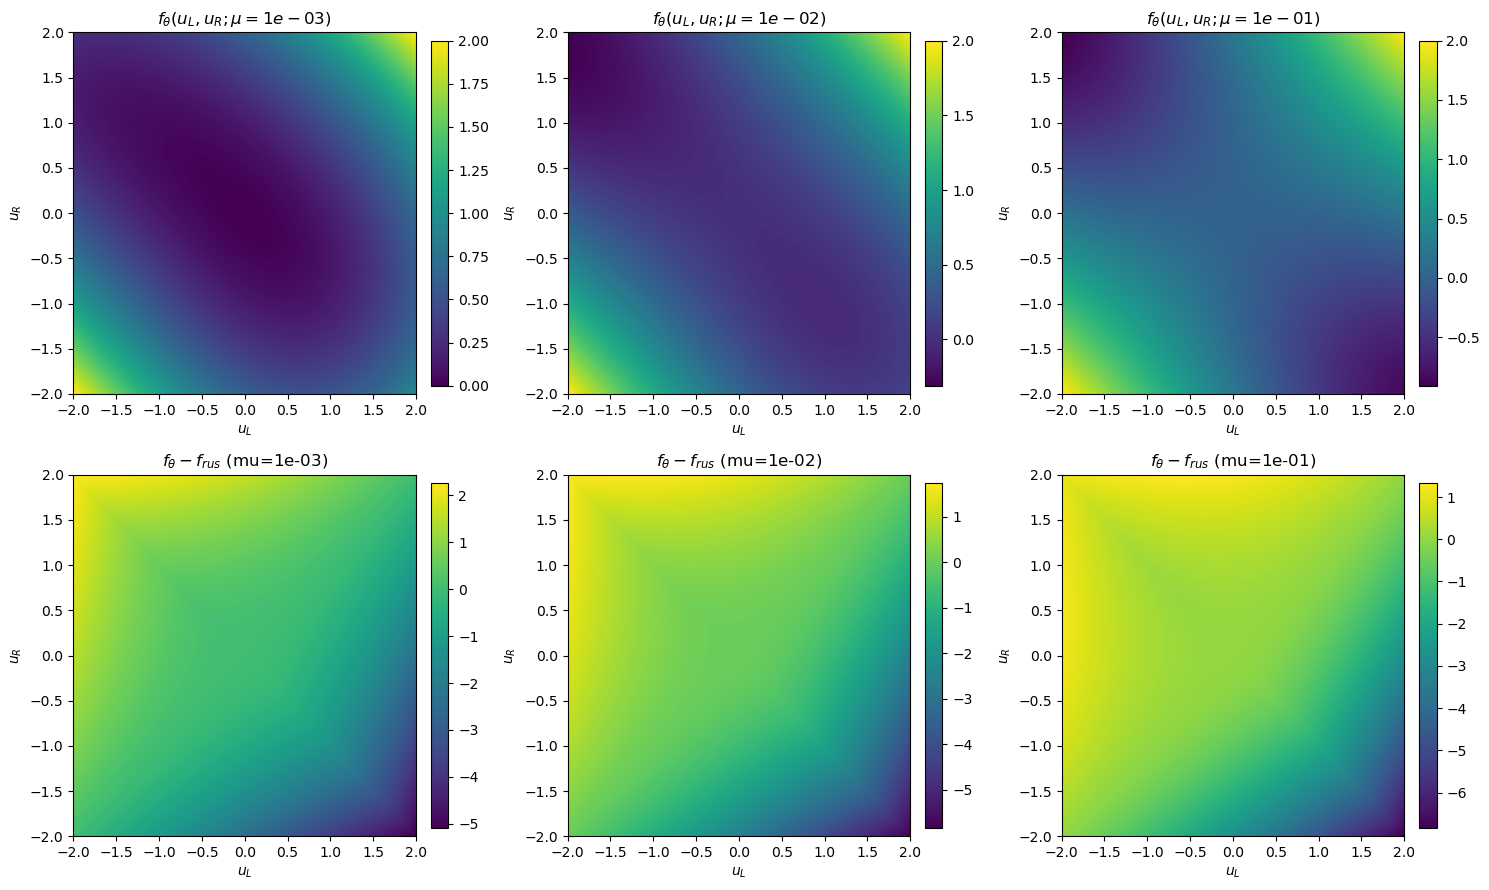

In [8]:
plot_flux_grid(model, mu_list=(1e-3, 1e-2, 1e-1))

In [9]:
def nn_flux_numpy(model, uL: np.ndarray, uR: np.ndarray, mu: float) -> np.ndarray:
    """
    Vectorized interface flux evaluation:
      uL,uR shape (N,)
      returns flux shape (N,)
    """
    uL = uL.astype(np.float32).reshape(-1, 1)
    uR = uR.astype(np.float32).reshape(-1, 1)
    log_mu = (np.log(mu) * np.ones_like(uL)).astype(np.float32)
    X = np.concatenate([uL, uR, log_mu], axis=1)  # (N,3)
    f = model(tf.convert_to_tensor(X)).numpy().reshape(-1)
    return f.astype(np.float64)

def laplacian_central_periodic(u: np.ndarray, dx: float) -> np.ndarray:
    return (np.roll(u, -1) - 2*u + np.roll(u, 1)) / (dx*dx)

def rhs_fv_burgers_nnflux(u: np.ndarray, dx: float, mu: float, model) -> np.ndarray:
    """
    Periodic FV semi-discrete RHS using neural flux for convection:
      u_t = -(F_{i+1/2} - F_{i-1/2})/dx + mu*u_xx
    """
    uL = u
    uR = np.roll(u, -1)
    F_iphalf = nn_flux_numpy(model, uL, uR, mu)      # i+1/2
    F_imhalf = np.roll(F_iphalf, 1)                  # i-1/2
    convection = -(F_iphalf - F_imhalf) / dx
    diffusion = mu * laplacian_central_periodic(u, dx)
    return convection + diffusion

def ssp_rk3_step(u: np.ndarray, dt: float, rhs_fun, *rhs_args) -> np.ndarray:
    u1 = u + dt * rhs_fun(u, *rhs_args)
    u2 = 0.75*u + 0.25*(u1 + dt*rhs_fun(u1, *rhs_args))
    u3 = (1.0/3.0)*u + (2.0/3.0)*(u2 + dt*rhs_fun(u2, *rhs_args))
    return u3

def stable_dt(u: np.ndarray, dx: float, mu: float, cfl: float) -> float:
    umax = float(np.max(np.abs(u)))
    dt_conv = np.inf if umax == 0.0 else cfl * dx / umax
    dt_diff = np.inf if mu == 0.0 else 0.45 * dx*dx / mu
    return min(dt_conv, dt_diff)


In [10]:
def test_nn_in_fv_solver(model, mu=1e-2, N=400, T=0.05, cfl=0.25, save_every=5):
    # periodic grid
    a, b = -1.0, 1.0
    x = np.linspace(a, b, N, endpoint=False)
    dx = float(x[1] - x[0])

    # ICs to stress-test
    def ic_sine(x): return np.sin(2*np.pi*x)
    def ic_step(x): return np.where(x < 0.0, 1.0, -1.0)

    for name, u0 in [("sine", ic_sine(x)), ("step", ic_step(x))]:
        u = u0.astype(np.float64).copy()
        t = 0.0
        n = 0

        times = [t]
        snaps = [u.copy()]

        mass0 = u.mean() * (b - a)

        while t < T - 1e-15:
            dt = stable_dt(u, dx, mu, cfl)
            if t + dt > T:
                dt = T - t

            u = ssp_rk3_step(u, dt, rhs_fv_burgers_nnflux, dx, mu, model)
            t += dt
            n += 1

            # hard failure checks
            if not np.isfinite(u).all():
                raise RuntimeError(f"NaN/Inf encountered for IC={name} at step {n}, t={t}")
            if np.max(np.abs(u)) > 1e6:
                raise RuntimeError(f"Blow-up detected for IC={name} at step {n}, t={t}")

            if (n % save_every) == 0 or t >= T - 1e-15:
                times.append(t)
                snaps.append(u.copy())

        mass = np.array([s.mean() * (b - a) for s in snaps])
        mass_drift = np.max(np.abs(mass - mass0))

        # Plot: initial vs final + mass drift
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(x, u0, label="t=0")
        plt.plot(x, snaps[-1], label=f"t={times[-1]:.3f}")
        plt.title(f"NN-flux FV rollout | IC={name} | mu={mu:.0e}")
        plt.xlabel("x"); plt.ylabel("u")
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(times, mass)
        plt.title(f"Mass vs time (drift={mass_drift:.2e})")
        plt.xlabel("t"); plt.ylabel(r"$\int u\,dx$ (approx)")
        plt.tight_layout()
        plt.show()

        print(f"[OK] IC={name}: steps={n}, final t={t:.4f}, max|u|={np.max(np.abs(snaps[-1])):.3e}, mass drift={mass_drift:.3e}")



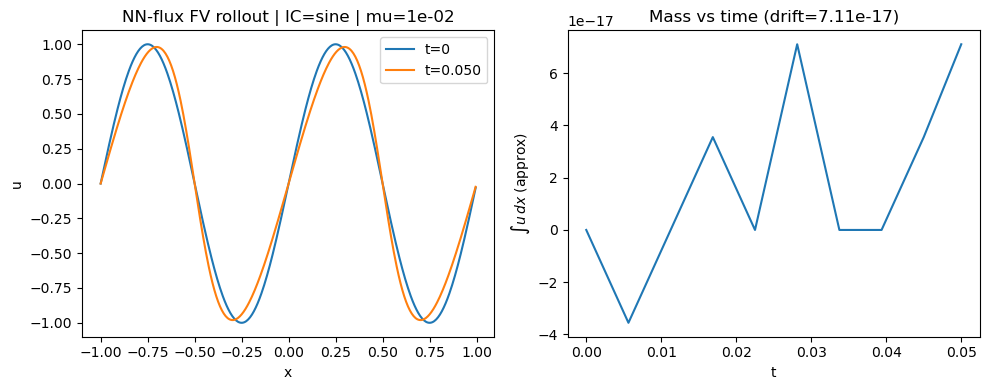

[OK] IC=sine: steps=45, final t=0.0500, max|u|=9.804e-01, mass drift=7.105e-17


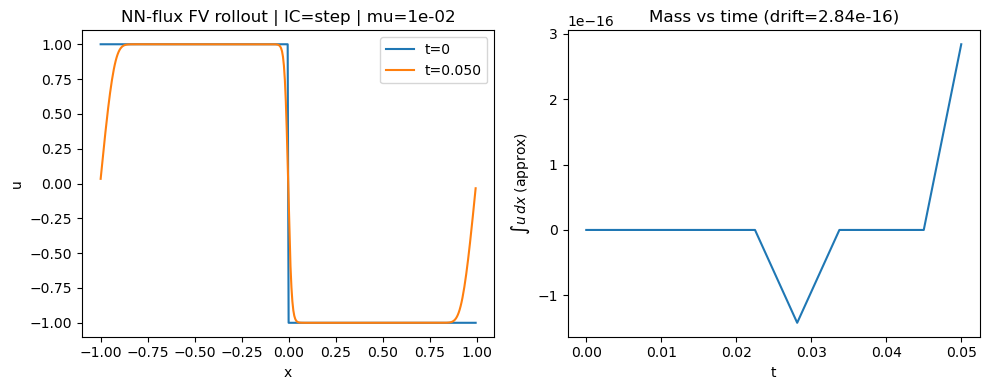

[OK] IC=step: steps=45, final t=0.0500, max|u|=1.000e+00, mass drift=2.842e-16


In [11]:
test_nn_in_fv_solver(model, mu=1e-2, N=400, T=0.05)